In [48]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')
import warnings
# warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm
import copy

from src.utils import scale_scores
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
with open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb') as f:
    customer_model = pickle.load(f)

### Data Processing
---

In [50]:
from utils import preprocess

In [51]:
# modeling_df
modeling_df = pd.read_feather('../../artifacts/modeling_df_final_with_oof_preds_replication.feather')
modeling_df = preprocess(modeling_df)

In [52]:
# get all and combine test_dfs
dfs = {}
dfs['jan'] = pd.read_feather('../../artifacts/oot_unscored_2020-01-06.feather')
dfs['feb'] = pd.read_feather('../../artifacts/oot_unscored_2020-02-17.feather')
dfs['mar'] = pd.read_feather('../../artifacts/oot_unscored_2020-03-15.feather')
dfs['apr'] = pd.read_feather('../../artifacts/oot_unscored_2020-04-15.feather')

In [53]:
cols = dfs['jan'].columns.tolist()  # to align columns just in case
cols.remove('index')
cols.remove('level_0')
test_df = pd.concat([df[cols] for df in dfs.values()])
test_df.reset_index(drop=True, inplace=True)
test_df.shape

(690863, 121)

In [54]:
test_df.head()

,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull,sample_date,borrower_id,...,first_deposit_amount,dollar_val_returns,is_chg_wrt_off_in_90d,days_to_acc_close,account_closed_by_risk_in_next_90d,last_unrestricted_date_in_next_90d,target,target_with_restriction,indeterminate,age_money_account
0,2714080,410002038142,2019-07-08,NaT,410,None,NaN,311,2020-01-06,2692521,...,500.00,0.0,False,NaN,False,False,False,False,False,182
1,13471528,410001288367,2019-03-25,NaT,410,None,NaN,416,2020-01-06,7293262,...,10.00,-4998.0,False,NaN,False,False,False,False,True,287
2,12689928,410001017437,2019-03-07,NaT,410,None,NaN,434,2020-01-06,6516922,...,1815.00,0.0,False,NaN,False,False,False,False,True,305
3,13471460,410001288655,2019-03-25,NaT,410,None,NaN,416,2020-01-06,7293195,...,NaN,NaN,False,NaN,False,False,False,False,True,287
4,2725268,410002223673,2019-07-27,NaT,410,None,NaN,292,2020-01-06,2705597,...,3999.92,0.0,False,NaN,False,True,False,False,False,163


In [55]:
test_df = preprocess(test_df)
test_df.head()

,user_id,business_account_number,date_account_opened,date_account_closed,account_type,account_closed_reason,joint_user_id,account_age_days_asof_pull,sample_date,borrower_id,...,days_to_acc_close,account_closed_by_risk_in_next_90d,last_unrestricted_date_in_next_90d,target,target_with_restriction,indeterminate,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
0,2714080,410002038142,2019-07-08,NaT,410,None,NaN,311,2020-01-06,2692521,...,NaN,False,False,False,False,False,182,2,-1.0,-1.0
1,13471528,410001288367,2019-03-25,NaT,410,None,NaN,416,2020-01-06,7293262,...,NaN,False,False,False,False,True,287,0,-1.0,998.0
2,12689928,410001017437,2019-03-07,NaT,410,None,NaN,434,2020-01-06,6516922,...,NaN,False,False,False,False,True,305,0,-1.0,-1.0
3,13471460,410001288655,2019-03-25,NaT,410,None,NaN,416,2020-01-06,7293195,...,NaN,False,False,False,False,True,287,0,997.0,998.0
4,2725268,410002223673,2019-07-27,NaT,410,None,NaN,292,2020-01-06,2705597,...,NaN,False,True,False,False,False,163,6,-1.0,-1.0


In [56]:
seed = 15556
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "n_boost_rounds": 1400,
    "max_depth" : 4,
    "num_leaves" : 15,
    "learning_rate" : 0.03,
    "feature_fraction" : 0.8,
    "subsample": 0.94,
    "lambda_l1": 16,
    "lambda_l2": 10,
    "min_data_in_leaf": 116,
    "tree_learner": "feature",
    "bagging_seed" : seed,
    "verbosity" : -1,
    "seed": seed,
    "categorical_feature": [39, 40, 41]
}

target_col = 'target'
count_pos = modeling_df['target'].sum()
count_neg = (~modeling_df['target']).sum()
pos_wgt_scaling_factor = count_neg / count_pos

params['scale_pos_weight'] = pos_wgt_scaling_factor

In [57]:
features = customer_model.feature_name_
len(features)

41

### WOE

In [58]:
import numpy as np
from rdsutils.woe import WOE_Transform

##### WOE on Pre-processed data

In [59]:
%%time 

# fit woe
woe = WOE_Transform(min_iv=-np.inf)
woe.fit(modeling_df[features], modeling_df[target_col].astype(int), display=-1)
df = woe.transform(modeling_df[features], train_data=1, keep=False)

# merge transformed data and record features
modeling_df = modeling_df.merge(df, how='inner', left_index=True, right_index=True)
features_woe = modeling_df.columns[modeling_df.columns.str.contains("woe")]

processed  41  num attributes

transformed num 20
transformed num 40

CPU times: user 1min 14s, sys: 8.5 s, total: 1min 23s
Wall time: 1min 23s


In [60]:
df = woe.transform(test_df[features], train_data=0, keep=False)
test_df = test_df.merge(df, how='inner', left_index=True, right_index=True)

transformed num 20
transformed num 40



divide by zero encountered in log
divide by zero encountered in log


#### Look at WOE, set Monotonic Constraints
---

In [61]:
import matplotlib.pyplot as plt

def plot_woe(fname, woe_dict, ax=None):
    if ax is None:
        fig = plt.figure()
    x = woe_dict[fname]["min"]
    y = woe_dict[fname]["woe"]
    ax.plot(x, y)
    ax.set_title(f"{fname}")
    

In [62]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_woe_plots(df, woe_dict, features, ncols=6, figsize=None, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in zip(features, axs.flatten()):
        plot_woe(feature, woe_dict, ax=ax)        
    return fig

In [63]:
plt.style.use('seaborn')

In [66]:
# sort features by importance
fimp = sorted(zip(customer_model.feature_importances_, customer_model.feature_name_), reverse=True)
features_by_imp = list(list(zip(*fimp))[1])
features_by_imp = [f+"_woe" for f in features_by_imp]
features_by_imp[:5]

['fraud_score_2_woe',
 'vantage_score_woe',
 'all8220_woe',
 'fraud_score_1_woe',
 'credit_card_loan_amount_woe']

In [ ]:
woe_dict = woe.woe_dict()
woe_dict = dict([(k+"_woe", v) for k,v in woe_dict.items()])
fig = get_woe_plots(modeling_df, woe_dict, features_by_imp)

In [ ]:
print("categorical features:")
features[38], features[39], features[40]

In [22]:
mc_constraints = {}
for k in features:
    if k not in [features[38], features[39], features[40]]:
        v = woe_dict[k+'_woe']
        mc_constraints[k] = int(v.loc[0,'woe'] < v.loc[1, 'woe']) * 2 - 1
    else:
        mc_constraints[k] = 0
    
mc_constraints

{'first_deposit_amount': -1,
 'vantage_score': -1,
 'bcc7120': 1,
 'email_risk_score': 1,
 'fraud_score_2': 1,
 'name_email_correlation': -1,
 'transaction_as_pct_of_balance': 1,
 'mean_account_balance_30d': -1,
 'phone_risk_score': 1,
 'name_address_correlation': -1,
 'all8220': -1,
 'lag_acc_open_first_transaction': 1,
 'dollar_val_dd': -1,
 'all7120': 1,
 'sum_deposits_10d': 1,
 'nr_past_transactions': -1,
 'total_tradelines_open': -1,
 'education_loan_amount': -1,
 'address_risk_score': 1,
 'iqt9415': 1,
 'max_withdrawals_30d': 1,
 'iln5520': -1,
 'max_deposits_30d': 1,
 'pct_returned_deposits': 1,
 'giact_nr_decline': 1,
 'nr_direct_deposits': -1,
 'time_since_last_transaction': -1,
 'bal_ratio': -1,
 'name_phone_correlation': -1,
 'giact_nr_other': 1,
 'dollar_val_returns': -1,
 'nr_trans_ratio': 1,
 'iqt9413': 1,
 'dollar_val_returns_3d': -1,
 'nr_returns_30d': 1,
 'credit_card_loan_amount': -1,
 'fraud_score_1': 1,
 'age_money_account': -1,
 'transaction_code_encoded': 0,
 'all

In [23]:
params['monotone_constraints'] = [mc_constraints[f] for f in features]
params['mc_method'] = 'basic'

In [24]:
params

{'objective': 'binary',
 'metric': 'auc',
 'boosting': 'gbdt',
 'n_boost_rounds': 1400,
 'max_depth': 4,
 'num_leaves': 15,
 'learning_rate': 0.03,
 'feature_fraction': 0.8,
 'subsample': 0.94,
 'lambda_l1': 16,
 'lambda_l2': 10,
 'min_data_in_leaf': 116,
 'tree_learner': 'feature',
 'bagging_seed': 15556,
 'verbosity': -1,
 'seed': 15556,
 'categorical_feature': [39, 40, 41],
 'scale_pos_weight': 21.33703498056635,
 'monotone_constraints': [-1,
  -1,
  1,
  1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  -1,
  1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  0,
  0,
  0],
 'mc_method': 'basic'}

In [25]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score


def train_lgb_baseline_grouped(df, features, params, target_col_name='target', 
                               group_col_name='business_account_number', num_folds=5, seed=12345, 
                               verbose_eval=500, weight_col_name=None, cat_features=None, prepro=None):
    """
    Train LightGBM models over 5 folds, return OOF predictions, trained models, and average AUC over 5 folds.
    """
    kf = GroupKFold(num_folds)
    split = kf.split(X=df, y=df[target_col_name], groups=df[group_col_name])

    train_pred = np.zeros(len(df))
    feature_importance_df = pd.DataFrame()

    models = []

    for i, (train_idx, test_idx) in enumerate(split):
        train = df.iloc[train_idx].copy()
        test = df.iloc[test_idx].copy()

        if weight_col_name:
            wtr = train[weight_col_name]
            wts = test[weight_col_name]
        else:
            wtr = None
            wts = None
            
        if prepro is not None:
            preprocessor = prepro
            train[cat_features] = prepro.fit_transform(X=train[cat_features], y=train[target_col_name])
            test[cat_features] = prepro.transform(test[cat_features])

        lgb_train = lgb.Dataset(train[features],
                                label=train[target_col_name],
                                free_raw_data=False,
                                weight=wtr)
        lgb_test = lgb.Dataset(test[features],
                               label=test[target_col_name],
                               free_raw_data=False,
                               weight=wts)

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_test],
                          valid_names=['train', 'test'],
                          verbose_eval=verbose_eval)
                
        models.append(model)

        train_pred[test_idx] = model.predict(test[features], num_iteration=model.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = model.feature_importance(importance_type='gain', 
                                                                    iteration=model.best_iteration)
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    auc = roc_auc_score(y_true=df[target_col_name].values, y_score=train_pred)

    return train_pred, feature_importance_df, models, auc


In [26]:
%%time 

n_boost_rounds = 1400
params_ = copy.deepcopy(params)
params_['num_iterations'] = n_boost_rounds

# OOS
pred, feature_importance_df, models, auc = train_lgb_baseline_grouped(
    modeling_df, features, params_, target_col_name='target', 
    group_col_name='business_account_number')
modeling_df[f'pred_w_mc'] = pred


In [28]:
%%time 
# OOT
mc_model = lgb.LGBMClassifier(**params_)
mc_model.fit(modeling_df[features], modeling_df['target'])
test_df[f'pred_w_mc'] = mc_model.predict_proba(test_df[features])[:, 1]

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: n_boost_rounds
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
CPU times: user 15min 55s, sys: 1.47 s, total: 15min 57s
Wall time: 27.2 s


In [29]:
%%time
#customer model preds
test_df['pred_wo_mc'] = customer_model.predict_proba(test_df[features])[:, 1]

CPU times: user 1min 30s, sys: 353 ms, total: 1min 30s
Wall time: 3.25 s


### Comparsion
---

In [30]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult, plot_feature_over_time

plt.style.use('seaborn')

def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap,
               'ks': ks}

    return metrics


def get_pred_reports(df, target_col, pred_cols):
    import pandas as pd
    result = {}
    for col in pred_cols:
        metrics = get_binary_metrics(df[target_col], df[col])
        result[col] = metrics
    return pd.DataFrame(result).T

In [31]:
test_df = test_df[(test_df.nr_transactions_next_90d > 0) & (test_df.nr_past_transactions > 0)]

In [32]:
test_df.to_parquet("../../artifacts/governance/monotonic_constraints?/test_df.parquet")

In [33]:
print('OOT')
metrics = get_pred_reports(test_df, target_col, 
                           ['pred_wo_mc', 'pred_w_mc'])
display(metrics.sort_values('ap'))

OOT


,auc,ap,ks
pred_w_mc,95.51,53.49,80.32
pred_wo_mc,95.90,54.91,80.78


In [34]:
def plot_pr_curve_mult(y_test, y_scores, title=None, 
                       colors=['b'], figsize=None,
                       ax=None, fig=None, fill=True, **kwargs):
    """Plot multiple precision-recall curves on the same canvas.
    
    Parameters
    ----------
    y_test : pd.Series, np.ndarray - shape [n]
        Targets.
    y_scores: [(y_score, label), ...]
        list of tuples with y_score and corresponding label
        y_score - pd.Series
        label - str - label to show in legend
    title: str
        title for the plot
    colors: list(str)
        list of colors for the y_scores respectively
    figsize: tuple(int)
        figure size for plt
    
        
    Returns
    -------
    fig:
        matplotlib figure
    ax:
        matplotlib axis
    """
    assert(len(y_scores) == len(colors))
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    aps = []
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    if colors is None:
        colors = sns.color_palette(n_colors=len(y_scores))
            
    for i in range(len(y_scores)):
        y_score, label = y_scores[i]
        
        average_precision = average_precision_score(y_test, y_score)
        aps.append(average_precision)
        precision, recall, _ = precision_recall_curve(y_test, y_score, **kwargs)
        
        if fill:
            ax.fill_between(recall, precision, alpha=0.2, color=colors[i])
            
            ax.step(recall, precision, color=colors[i], alpha=0.2,
                     where='post', label=label)
        
        else:
            ax.step(recall, precision, color=colors[i], alpha=0.5,
                 where='post', label=label)
    
    ax.legend()

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    
    return fig, ax

def plot_auc_curve_mult(y_test, y_scores, title, 
                        colors=None, figsize=None,
                        ax=None, fig=None, fill=True, **kwargs):
    """Plot multiple AUC-ROC curves on the same canvas.
    
    Parameters
    ----------
    y_test : pd.Series, np.ndarray - shape [n]
        Targets.
    y_scores: [(y_score, label), ...]
        list of tuples with y_score and corresponding label
        y_score - pd.Series
        label - str - label to show in legend
    title: str
        title for the plot
    colors: list(str)
        list of colors for the y_scores respectively
    figsize: tuple(int)
        figure size for plt
    
        
    Returns
    -------
    fig:
        matplotlib figure
    ax:
        matplotlib axis
    """
    assert(len(y_scores) == len(colors))
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    aucs = []
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    if colors is None:
        colors = sns.color_palette(n_colors=len(y_scores))
            
    for i in range(len(y_scores)):
        y_score, label = y_scores[i]
        
        aucroc = roc_auc_score(y_test, y_score)
        aucs.append(aucroc)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        
        if fill:
            ax.fill_between(fpr, tpr, alpha=0.2, color=colors[i])
            
            ax.step(fpr, tpr, color=colors[i], alpha=0.2,
                 where='post', label=label)
            
        else:
            ax.step(fpr, tpr, color=colors[i], alpha=0.5,
                 where='post', label=label)
        
    plt.legend()

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    
    return fig, ax

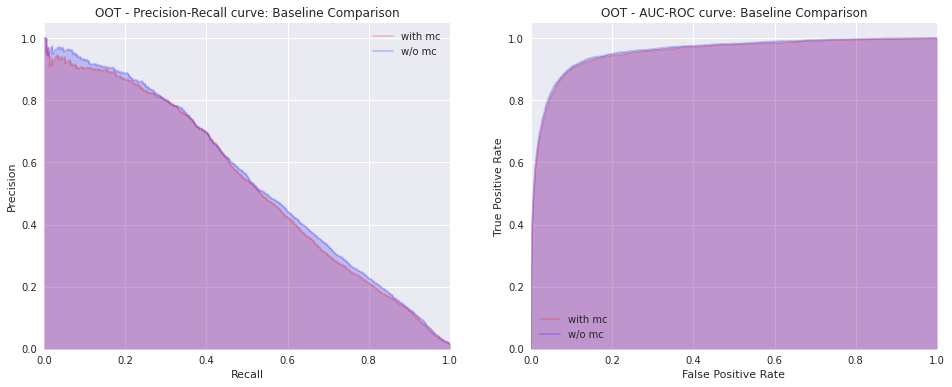

In [35]:
# OOT best predictions
fig, axs = plt.subplots(1, 2, figsize=(16,6))

preds = [(test_df['pred_w_mc'], 'with mc'), 
         (test_df['pred_wo_mc'], 'w/o mc')
        ]

title = 'OOT - Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(test_df[target_col], preds,
                   title=title, colors = ['r', 'b'], 
                   ax=axs[0], fig=fig) 

title = 'OOT - AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(test_df[target_col], preds,
                   title=title, colors = ['r', 'b'], 
                   ax=axs[1], fig=fig)
plt.show()

#### SHAP

In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_shap_dependence(df, shap_values, features, ncols=6, figsize=None, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in zip(features, axs.flatten()):
        shap.dependence_plot(feature, shap_values, df, 
                             ax=ax, show=False, **kwargs)
        rlim = df[feature].quantile(0.98)
        llim = df[feature].quantile(0.02) - ((rlim - df[feature].quantile(0.02)) / 12)
            
        if rlim < np.inf and llim > -np.inf:
            ax.set_xlim(left=llim, right=rlim)
        
    return fig

#### Without MC

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.


CPU times: user 2h 25min 31s, sys: 3.77 s, total: 2h 25min 34s
Wall time: 4min 2s


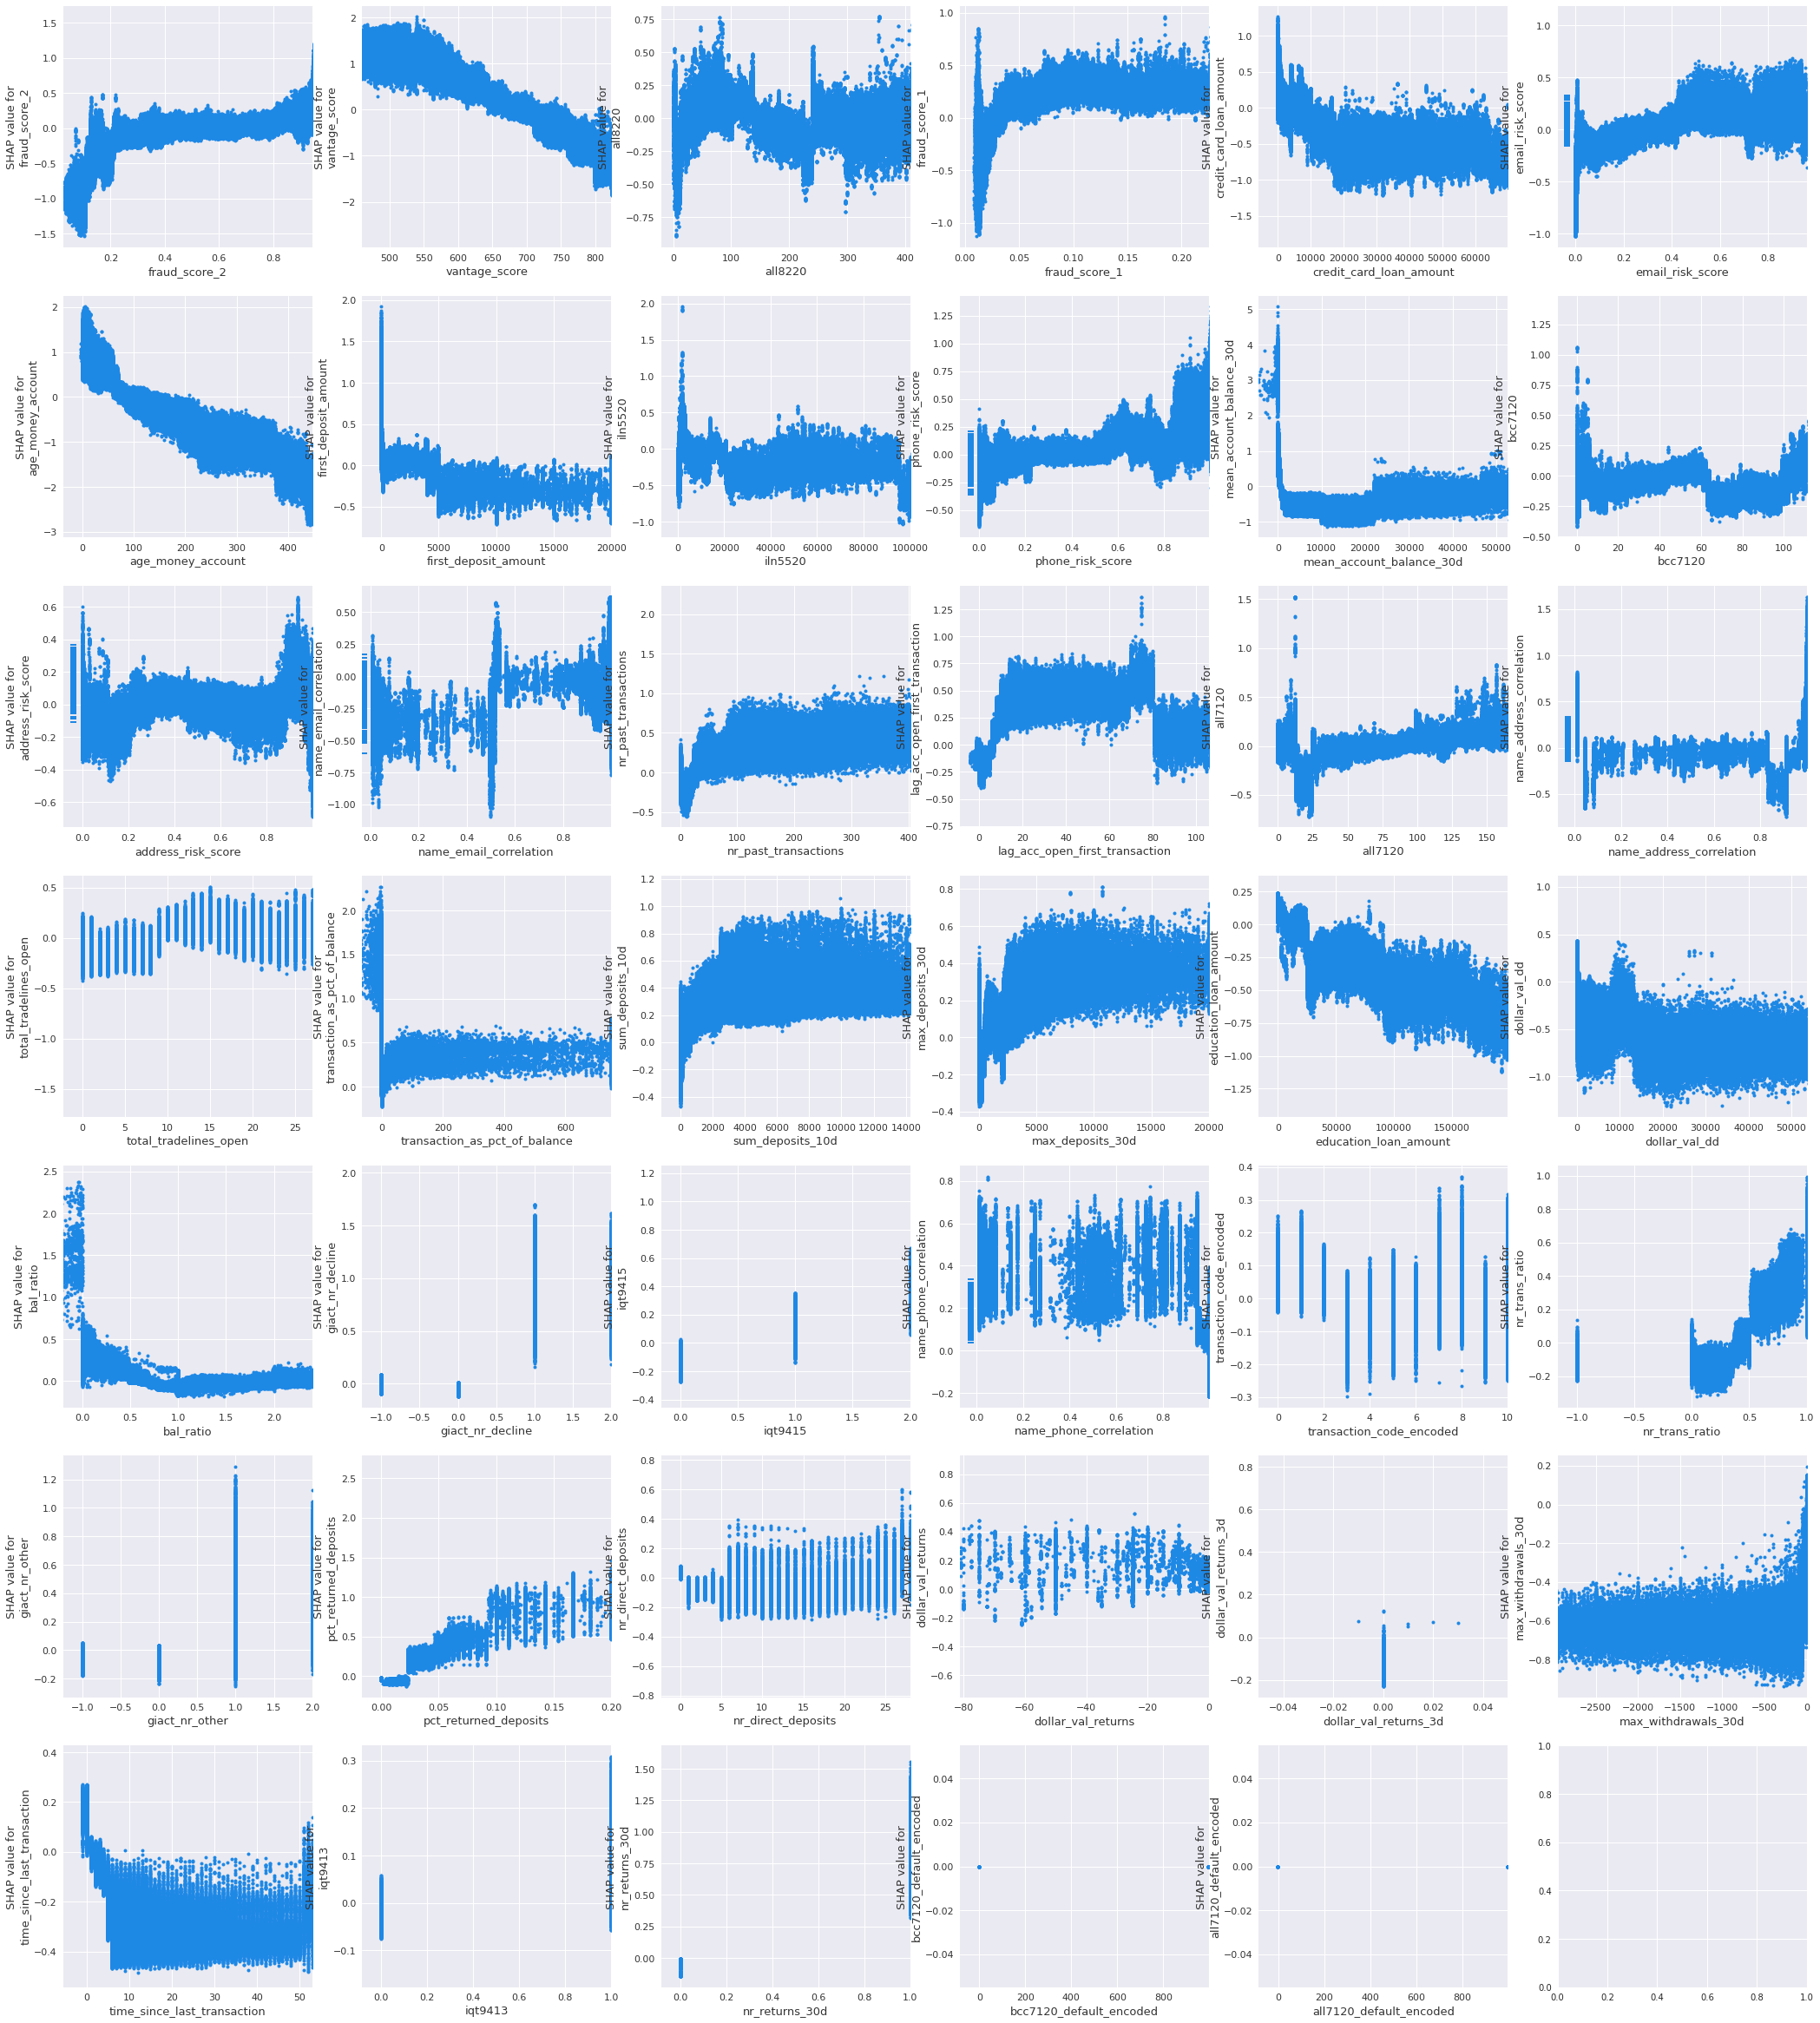

In [38]:
%%time
import shap

# generate shap values
shap.initjs()
explainer = shap.TreeExplainer(customer_model)
shap_values = explainer.shap_values(modeling_df[customer_model.feature_name_])[1]

# if we use probability option: more interpretable, more time consuming
# explainer = shap.TreeExplainer(model, data=sample, model_output=model_output)  ## probability
# shap_values = explainer.shap_values(modeling_df[model.feature_name_])

# sort features by importance, prep for plotting
fimp = sorted(zip(customer_model.feature_importances_, 
                  customer_model.feature_name_), reverse=True)
features_by_imp = list(list(zip(*fimp))[1])

fig = get_shap_dependence(modeling_df[customer_model.feature_name_], 
                          shap_values, features_by_imp, interaction_index=None)
# fig.savefig('../../artifacts/governance/shap_values_customer.png')

#### MC enforced Model

In [39]:
fimp = sorted(zip(mc_model.feature_importances_, 
                  mc_model.feature_name_), reverse=True)
features_by_imp_mc = list(list(zip(*fimp))[1])

In [40]:
%%time 

import shap

shap.initjs()
explainer = shap.TreeExplainer(mc_model)
shap_values = explainer.shap_values(modeling_df[mc_model.feature_name_])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


CPU times: user 1h 58min 20s, sys: 885 ms, total: 1h 58min 21s
Wall time: 3min 4s


Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.


CPU times: user 13.9 s, sys: 2.96 s, total: 16.9 s
Wall time: 16.9 s


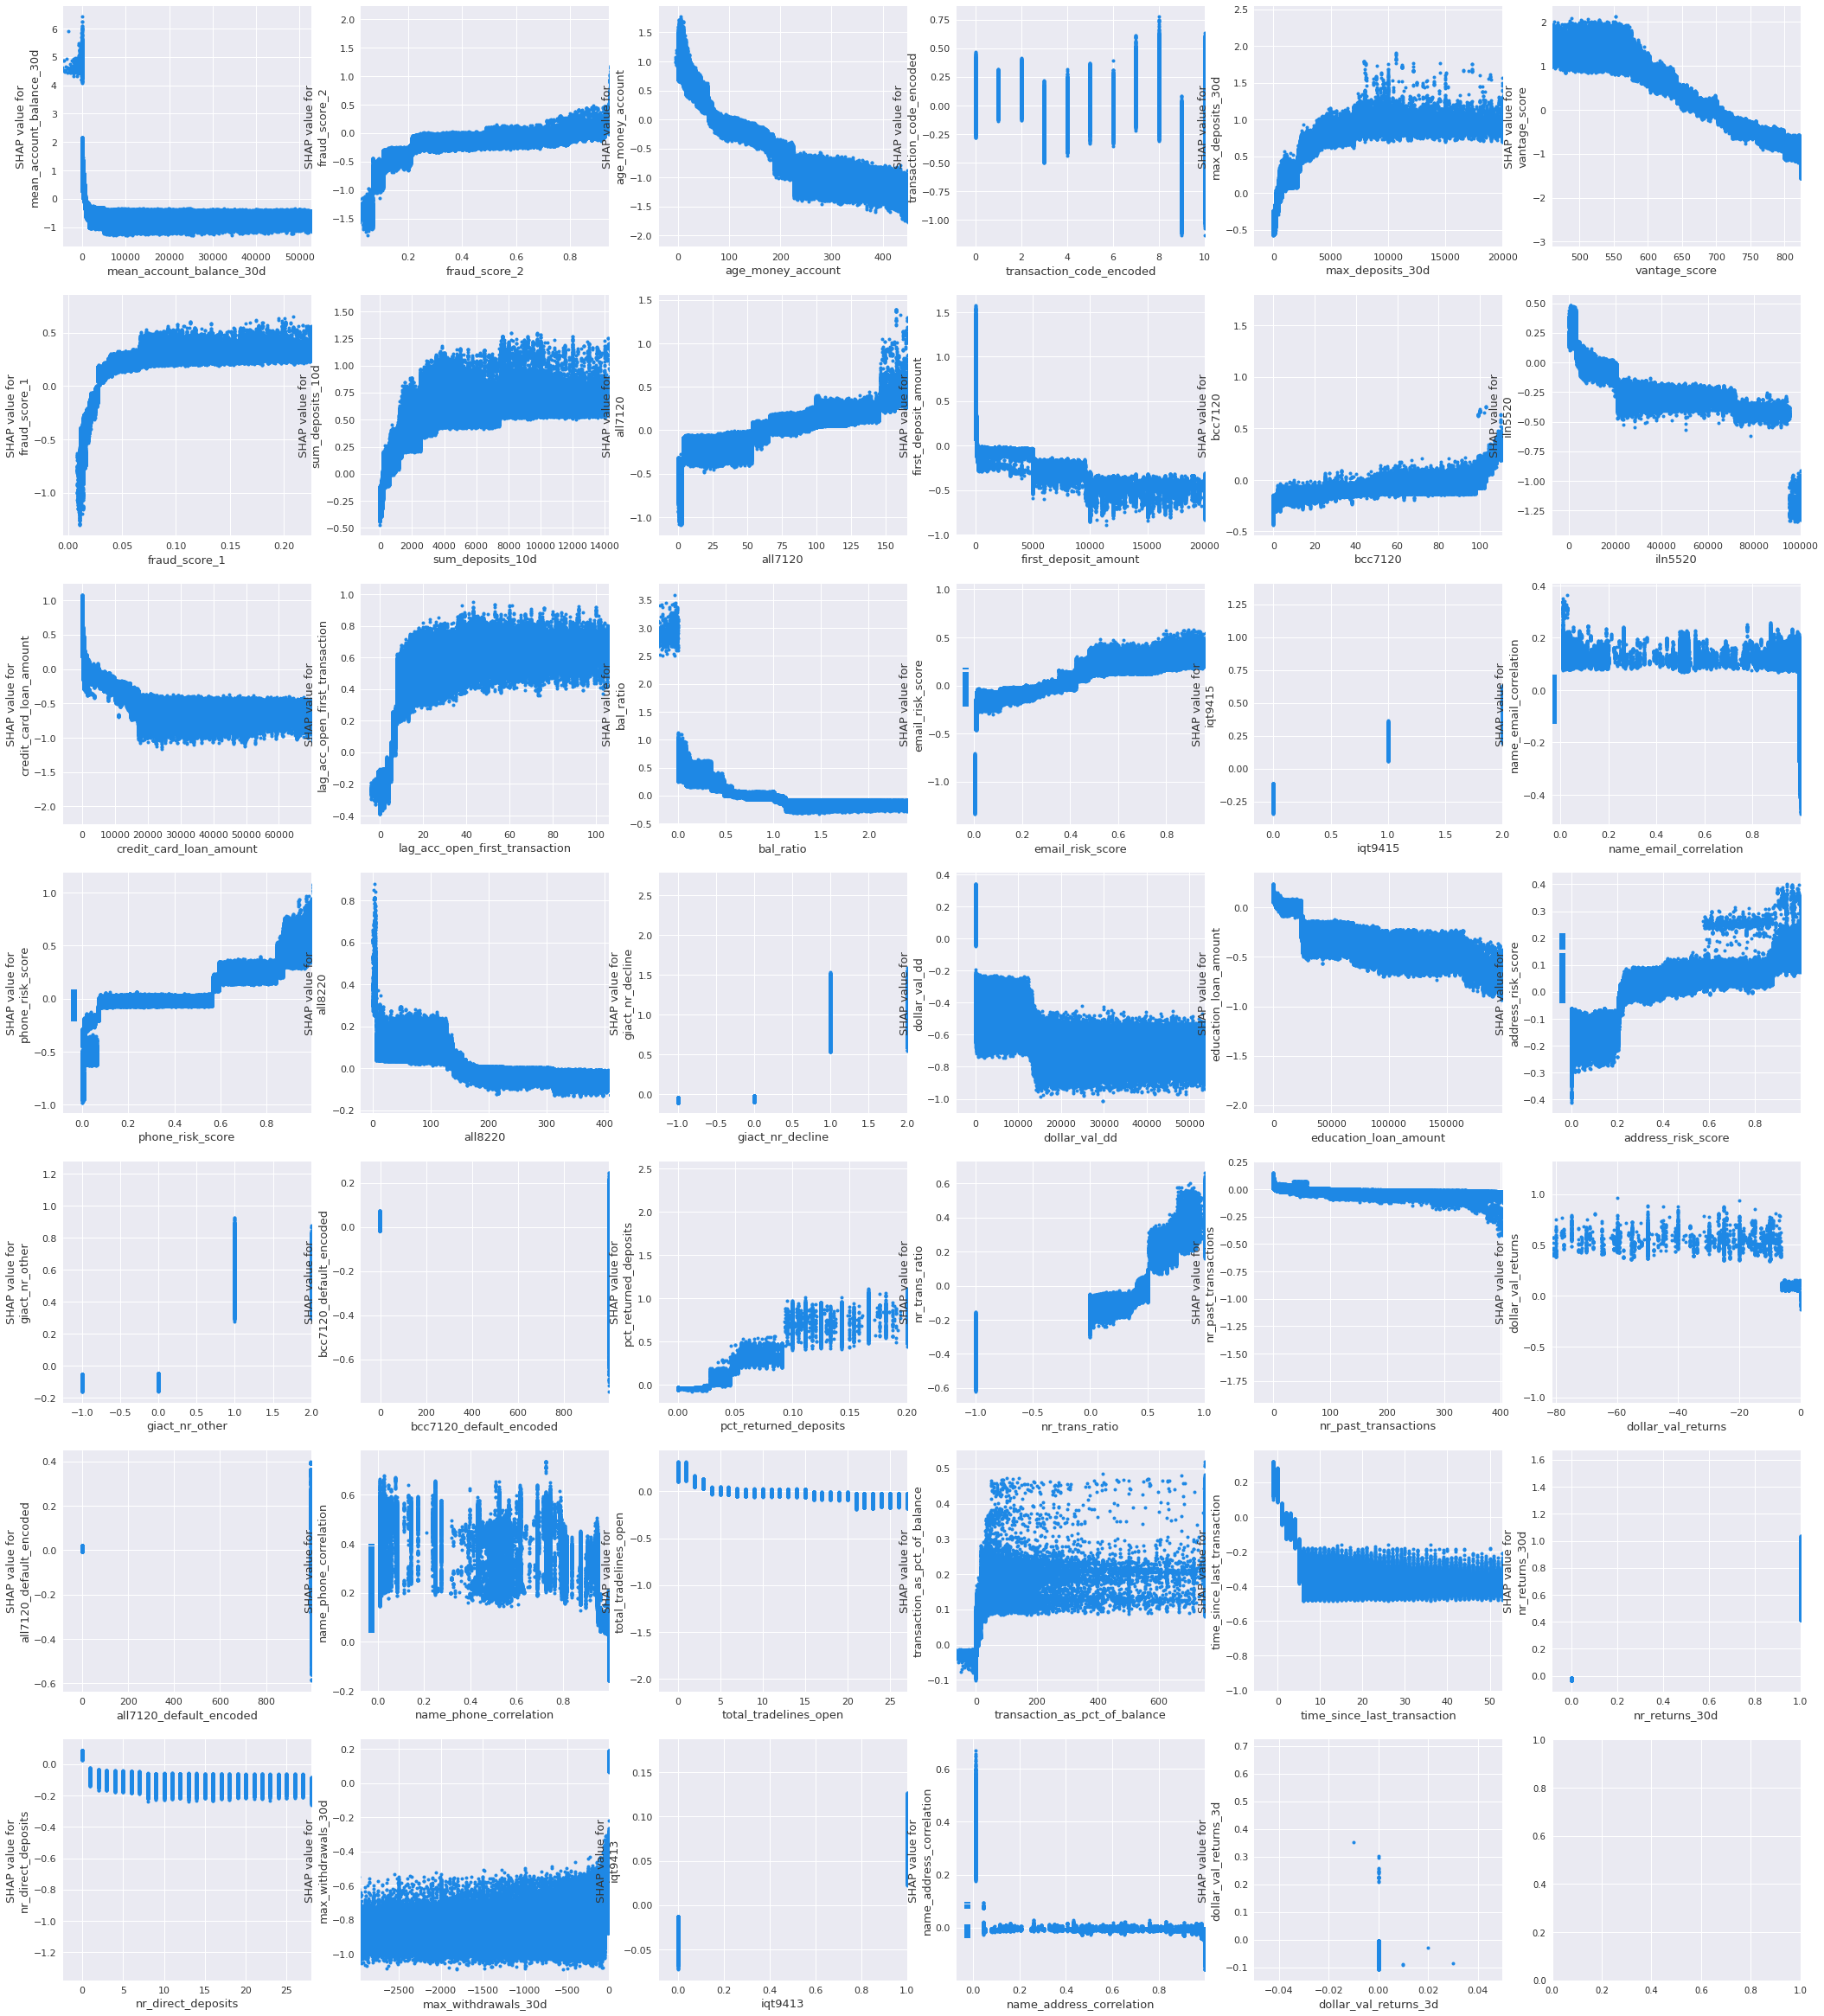

In [41]:
%%time
fig = get_shap_dependence(modeling_df[mc_model.feature_name_], 
                          shap_values[1], features_by_imp_mc, 
                          interaction_index=None)

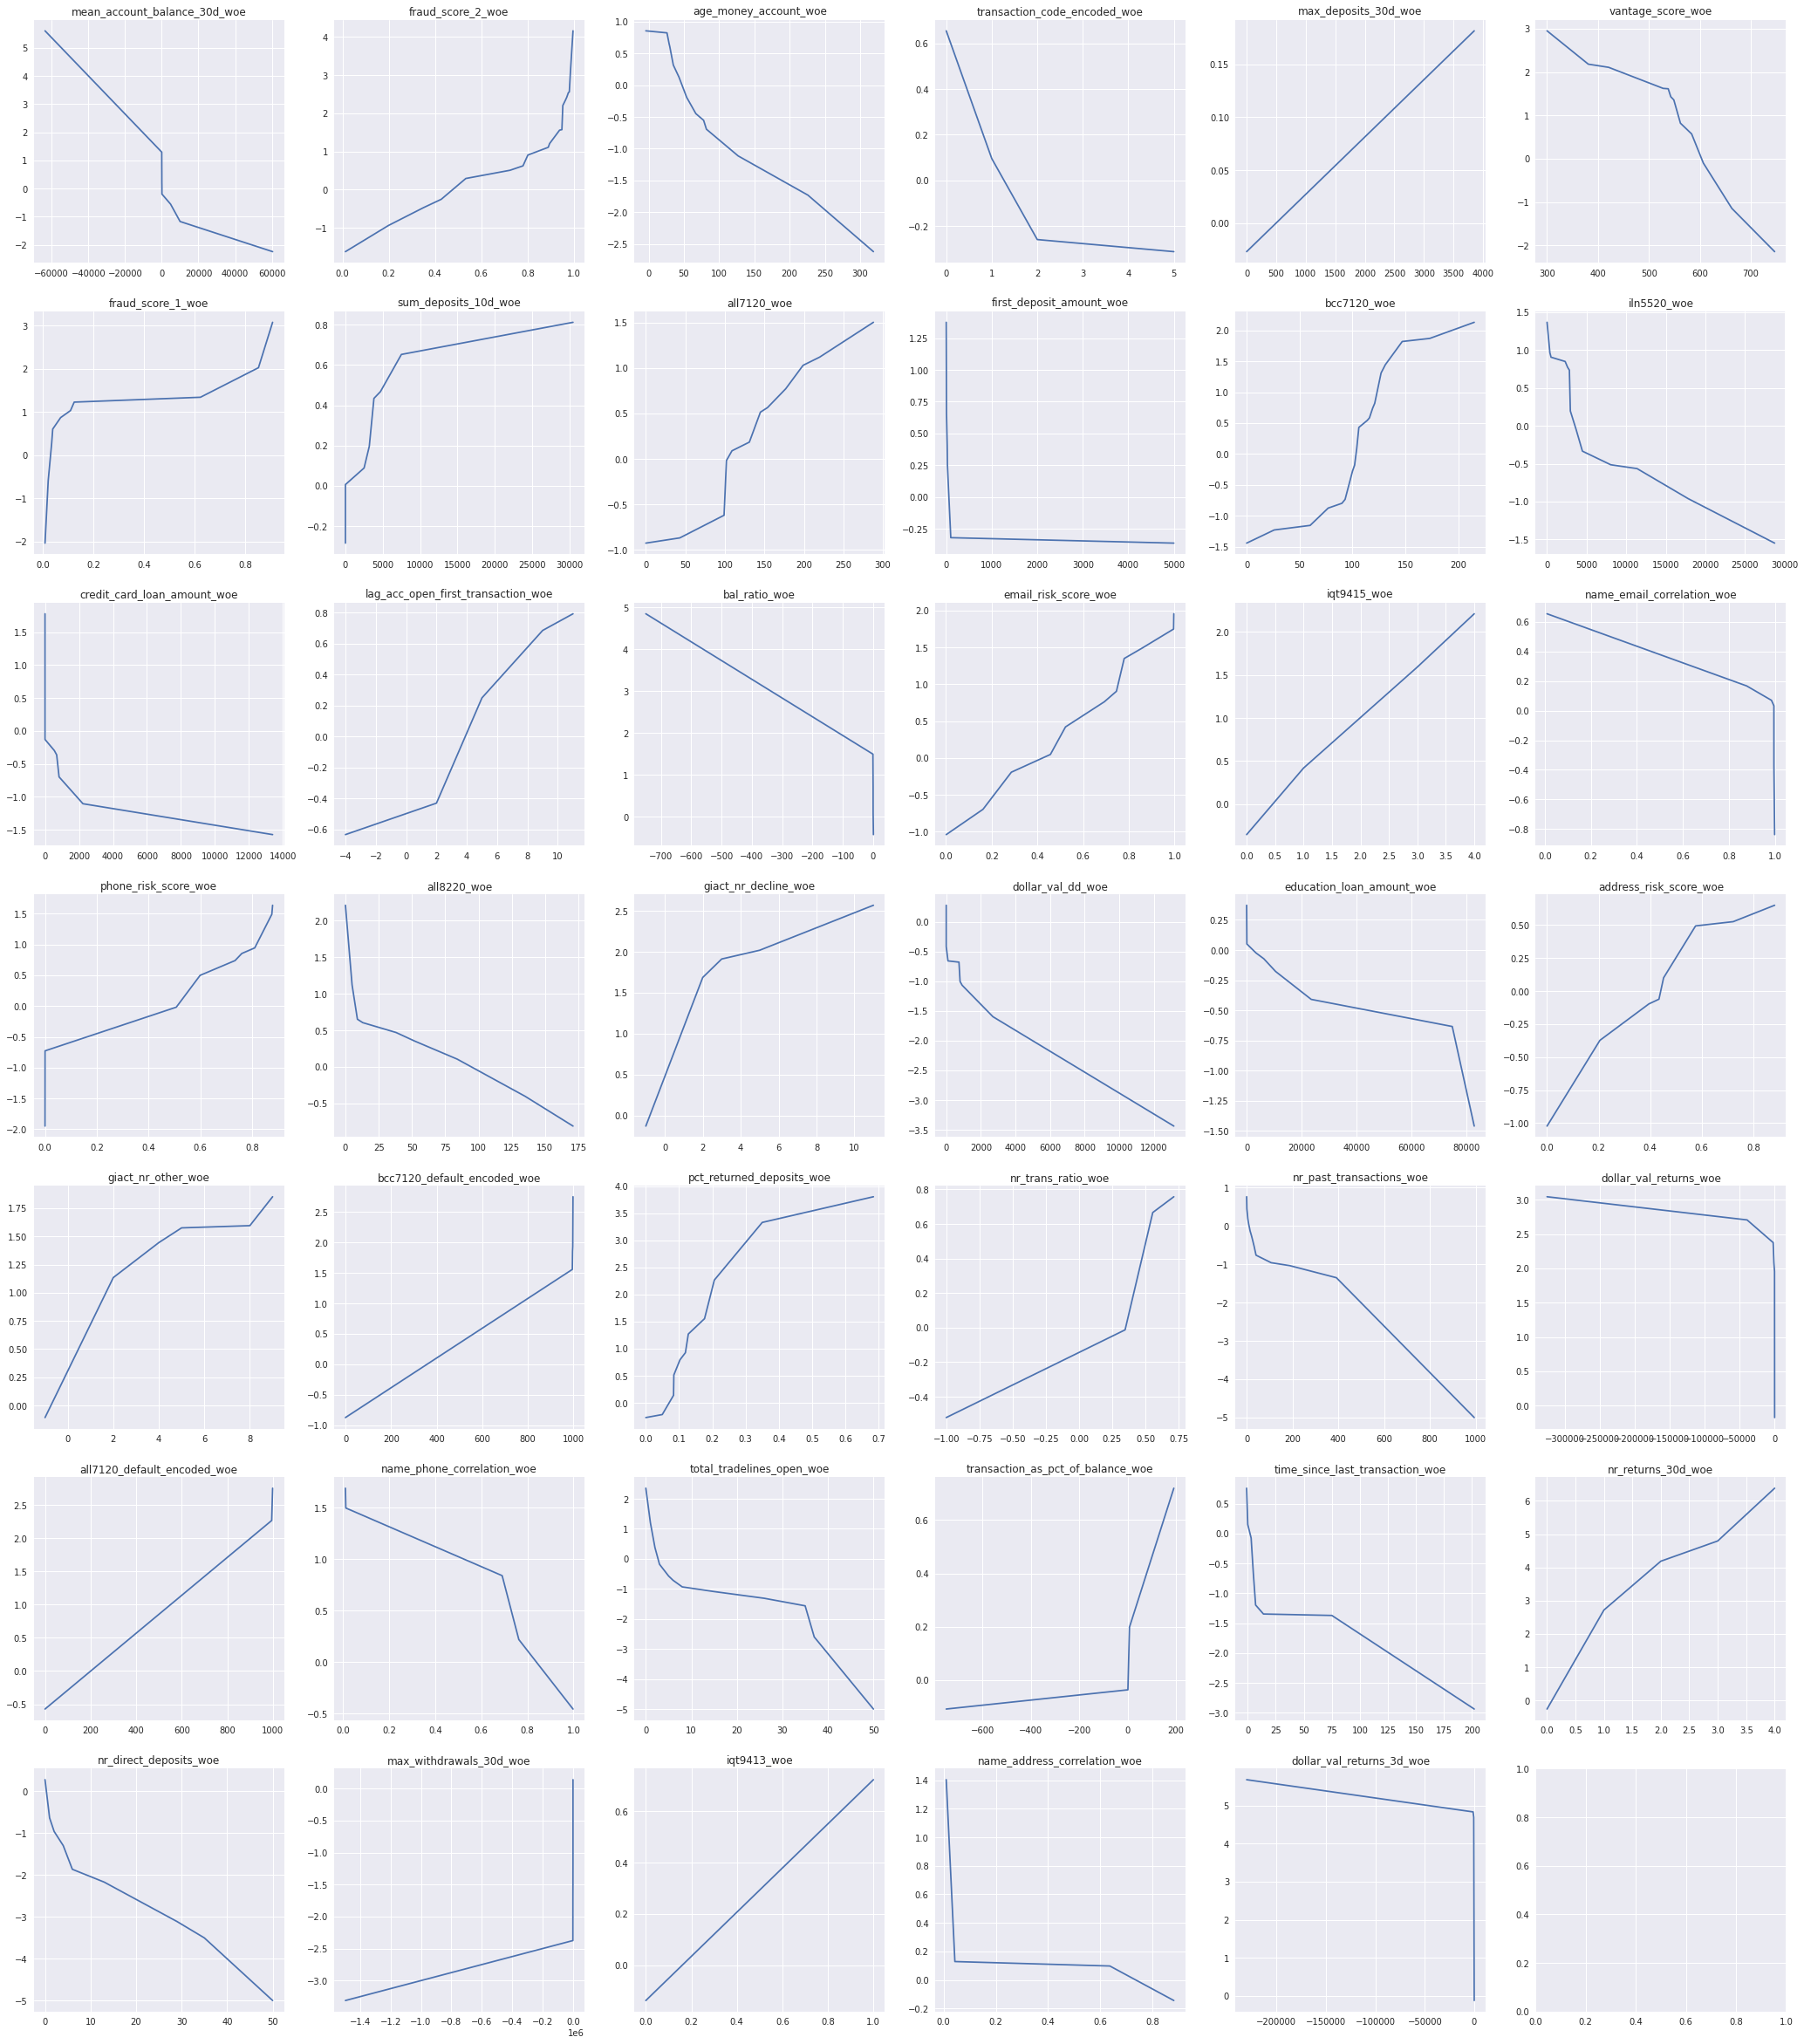

In [42]:
features_order = [k+"_woe" for k in features_by_imp_mc] # get the same order as lgbm + mc
fig = get_woe_plots(modeling_df, woe_dict, features_order)

#### Feature Importance
---

In [43]:
from rdsutils.plot import display_feature_importance

(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

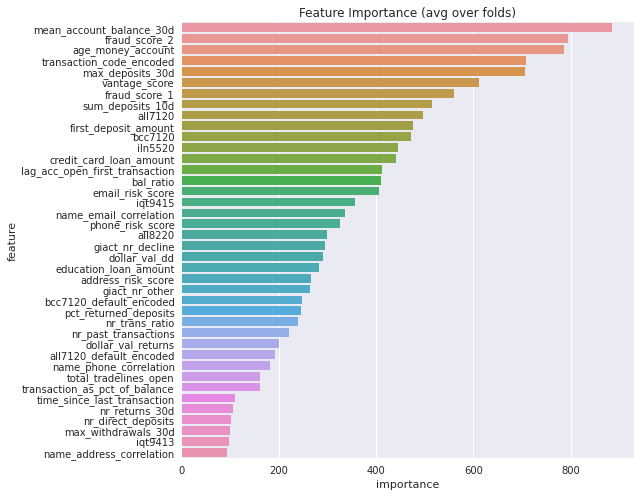

In [46]:
display_feature_importance(mc_model.feature_name_, 
                           mc_model.feature_importances_,
                           max_n_features=-1)

(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

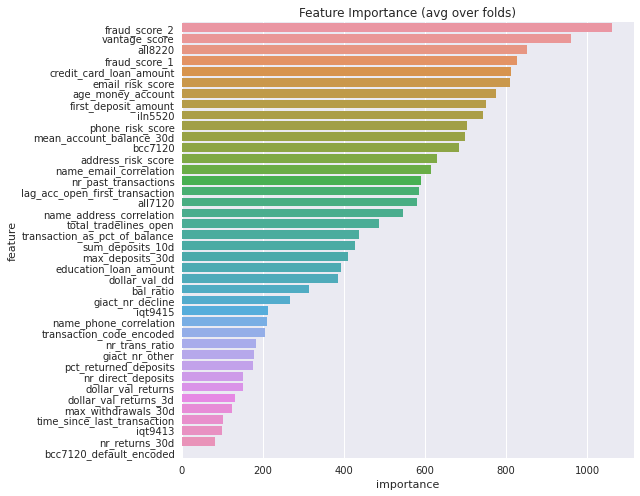

In [47]:
display_feature_importance(customer_model.feature_name_, 
                           customer_model.feature_importances_, 
                           max_n_features=-1)